# Modelling

In [26]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import modelling as ml
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
import pickle
import gzip, pickle, pickletools
import shap

sns.set_theme(context='notebook', style='darkgrid', palette='Set3')

In [27]:
# Import label encoded and ready for modelling set from 02 file 
df = pd.read_csv('../data/modelling_wines.csv')
df.set_index('name', inplace=True)
df.head()

,region,country,vintage,producer,wine_variety,grape_variety,price,rating,rating_qty,abv,from_vivino,age,log_price,log_rating_qty,age^2,rating * log_rating_qty
name,,,,,,,,,,,,,,,,
Starkconde Syrah 2017,213.0,18.0,30.0,6214.0,0.0,113.0,22.79,3.9,129.0,14.095184,1.0,7.0,3.126322,4.859812,49.0,18.953268
Montedidio Ostuni 2019,179.0,10.0,32.0,4935.0,1.0,124.0,6.29,4.0,347.0,12.910800,1.0,5.0,1.838961,5.849325,25.0,23.397299
Alto Estate Cabernet Sauvignon 2014,213.0,18.0,27.0,165.0,2.0,17.0,19.26,4.1,157.0,13.536861,1.0,10.0,2.958030,5.056246,100.0,20.730608
Chateau Belgrave Hautmedoc Grand Cru Classe 2016,103.0,5.0,29.0,1382.0,3.0,124.0,40.19,3.9,199.0,12.800353,1.0,8.0,3.693618,5.293305,64.0,20.643889
Tate Spring Street Cabernet Sauvignon 2019,163.0,22.0,32.0,6305.0,0.0,17.0,66.53,4.7,24.0,14.300000,0.0,5.0,4.197653,3.178054,25.0,14.936853


In [28]:
# Chose to drop abv as it was highly imputed (70% of the data). Dropped from_vivino as it is not useful for production model or app.
df.drop(columns = ['abv', 'from_vivino'], inplace=True)

# Baseline Model

Basic Linear Regression with abv nulls imputed via linear regression. 

In [29]:
X = df.drop(columns = ['log_price', 'price', 'vintage'])
y = df['log_price']

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y, random_state=42, train_size=0.85)

lr = LinearRegression()

lr.fit(X_train_lr, y_train_lr)
y_pred_lr = lr.predict(X_test_lr)

print(f"Price Root Mean Squared Error (RMSE): {round(np.exp(np.sqrt(mean_squared_error(y_test_lr, y_pred_lr))),3)}")
print(f"Log-Price Root Mean Squared Error (RMSE): {round(np.sqrt(mean_squared_error(y_test_lr, y_pred_lr)),3)}")
print(f"R-squared (R2): {round(r2_score(y_test_lr, y_pred_lr),3)}")
print(f"Cross validated r2: {round(cross_val_score(lr, X_train_lr, y_train_lr, cv = 10,scoring='r2').mean(), 3)}")

Price Root Mean Squared Error (RMSE): 1.677
Log-Price Root Mean Squared Error (RMSE): 0.517
R-squared (R2): 0.633
Cross validated r2: 0.633


In [30]:
# Put coefficients into a dataframe with index and columns
coef_df = pd.DataFrame(lr.coef_, X.columns, columns=['Coefficient'])
coef_df.sort_values(by=['Coefficient'], ascending=False, inplace=True)
coef_df

,Coefficient
rating,0.830439
rating * log_rating_qty,0.185656
age,0.135128
producer,-0.000013
rating_qty,-0.000038
grape_variety,-0.000133
region,-0.000205
age^2,-0.002182
country,-0.012330
wine_variety,-0.018898


* Model relying heavily on non-categorical coefficients - rating, rating *  log_rating_qty, age, log_rating_qty. 
* Logartithmic transformations proved to aid model predictivness for both price as a target and rating_qty.
* Categoricals which are label encoded grape_variety, producer, region, country performed poorly as to be expected with a linear regression model. Binary encoding was attempted of select categoricals, along with PCA to reduce dimensionality how ever best models proved to be decison tree based regressions with label encoding. 

In [31]:
results = ml.regression_model_selector(X_train_lr, y_train_lr, X_test_lr, y_test_lr, quick=True)
results

Not using StandardScaler


,model,rmse,cv,train_score,test_score,varience
0,lr,0.516807,0.633175,0.633512,0.633099,0.000413
1,ridge,0.516806,0.633176,0.633512,0.633101,0.000411
2,knn,0.521162,0.552403,0.791408,0.626889,0.164519
3,dt,0.307919,0.839884,0.999911,0.869754,0.130157


**Results of other models tested with same inputs:**
|index|model|rmse|cv|train_score|test_score|varience
|---|---|---|---|---|---|---|
|0|lr|0.523012|0.634073|0.634886|0.631206|0.003680|
|1|ridge|0.523014|0.634073|0.634886|0.631203|0.003683|
|2|knn|0.528168|0.539322|0.782727|0.623898|0.158828|
|3|dt|0.298107|0.847410|0.999962|0.880187|0.119775|
|4|RF|0.231445|0.910326|0.989422|0.927780|0.061641|
|5|adab|0.528435|0.634300|0.625589|0.623518|0.002071|
|6|svr|0.755754|0.239027|0.244181|0.229945|0.014235|


In [32]:
# results['date/desc'] = '7/3 | ABV imputed LR | Target: PRICE | Features: all features label encoded'
# model_tracker_current = pd.read_csv('../data/model_tracker.csv')
# model_tracker_current = pd.concat([model_tracker_current, results])
# model_tracker_current.to_csv('../data/model_tracker.csv', index=False)
# model_tracker_current

## Decision Tree Regression

In [33]:
# No hyper parameter tuning with a decision tree model. 

X_decision_trees = df.drop(columns = ['log_price', 'price', 'age', 'age^2'])

X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_decision_trees, y, random_state=42, train_size=0.85)

dt = DecisionTreeRegressor(random_state=42)

dt.fit(X_train_dt, y_train_dt)

y_pred_dt = dt.predict(X_test_dt)

print(f"Log-price Root Mean Squared Error (RMSE): {(np.sqrt(mean_squared_error(y_test_dt, y_pred_dt)))}")
print(f"Price USD Root Mean Squared Error (RMSE): {(np.exp(np.sqrt(mean_squared_error(y_test_dt, y_pred_dt))))}")
print(f"R-squared (R2): {r2_score(y_test_dt, y_pred_dt)}")

Log-price Root Mean Squared Error (RMSE): 0.3105776366413246
Price USD Root Mean Squared Error (RMSE): 1.3642129059426056
R-squared (R2): 0.8674949737615862


Log-price Root Mean Squared Error (RMSE): 0.31<br>
Price USD Root Mean Squared Error (RMSE): 1.36<br>
R-squared (R2): 0.867<br>

In [34]:
dt = DecisionTreeRegressor(random_state=42)
param_grid = {
    'max_depth': [10, 50, 60, 70, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2]
}

gs = GridSearchCV(estimator=dt, param_grid=param_grid, 
                           cv=5, 
                           verbose=0, n_jobs=-1)

gs.fit(X_train_dt, y_train_dt)

print("Best params: ", gs.best_params_)
print("Best score: ", gs.best_score_)

best_model = gs.best_estimator_

y_pred_dt_gs = best_model.predict(X_test_dt)
mse = mean_squared_error(y_test_dt, y_pred_dt_gs)
print(f"Test log Price RMSE: {np.sqrt(mse)}")
print(f"Test Price USD RMSE: {np.exp(np.sqrt(mse))}")

# Best params:  {'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 5}
# Best score:  0.8433011020047225
# Test log Price RMSE: 0.3090397402553921
# Test Price USD RMSE: 1.3621165002854443

Best params:  {'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best score:  0.8433011020047225
Test log Price RMSE: 0.3090397402553921
Test Price USD RMSE: 1.3621165002854443


In [35]:
# After hyper parameter tuning
best_model.fit(X_train_dt, y_train_dt)
y_pred_dt_tuned = best_model.predict(X_test_dt)

print(f"Price Root Mean Squared Error (RMSE): {round(np.exp(np.sqrt(mean_squared_error(y_test_dt, y_pred_dt_tuned))),3)}")
print(f"Log-price Root Mean Squared Error (RMSE): {round(np.sqrt(mean_squared_error(y_test_dt, y_pred_dt_tuned)),3)}")
print(f"R-squared (R2): {round(r2_score(y_test_dt, y_pred_dt_tuned),3)}")
print(f"Cross validated r2: {round(cross_val_score(best_model, X_train_dt, y_train_dt, cv = 5).mean(), 3)}")

Price Root Mean Squared Error (RMSE): 1.362
Log-price Root Mean Squared Error (RMSE): 0.309
R-squared (R2): 0.869
Cross validated r2: 0.843


In [36]:
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(10):
    print(f"{f + 1}. feature {X_decision_trees.columns[indices[f]]} ({importances[indices[f]]:.3f})")

Feature ranking:
1. feature rating (0.571)
2. feature vintage (0.122)
3. feature region (0.069)
4. feature producer (0.064)
5. feature country (0.061)
6. feature rating_qty (0.029)
7. feature rating * log_rating_qty (0.028)
8. feature grape_variety (0.026)
9. feature log_rating_qty (0.024)
10. feature wine_variety (0.007)


## Random Forests Regression 

In [37]:
# # Commented out for reproducibility speed.
# rf = RandomForestRegressor(random_state=42)
# param_grid = {
#     'max_depth': [120, 150],
#     'min_samples_split': [2],
#     'min_samples_leaf': [1]
# }

# gs = GridSearchCV(estimator=rf, param_grid=param_grid, 
#                            cv=5, verbose=0, n_jobs=-1)

# gs.fit(X_train_dt, y_train_dt)

# print("Best params: ", gs.best_params_)
# print("Best score:", gs.best_score_)
# rf_best_model = gs.best_estimator_

# y_pred_rf = rf_best_model.predict(X_test_dt)
# mse = mean_squared_error(y_test_dt, y_pred_rf)

# print(f"Price Root Mean Squared Error (RMSE): {round(np.exp(np.sqrt(mse)),3)}")
# print(f"Log-price Root Mean Squared Error (RMSE): {round(np.sqrt(mse),3)}")
# print(f"R-squared (R2): {round(r2_score(y_test_dt, y_pred_rf),3)}")
# print(f"Cross validated r2: {round(cross_val_score(rf_best_model, X_train_dt, y_train_dt, cv = 5).mean(), 3)}")



Best params:  {'max_depth': 120, 'min_samples_leaf': 1, 'min_samples_split': 2}<br>
Best score: 0.9023414270094839<br>
Price Root Mean Squared Error (RMSE): 1.272<br>
Log-price Root Mean Squared Error (RMSE): 0.24<br>
R-squared (R2): 0.919<br>

In [38]:
rf = RandomForestRegressor(max_depth = 120, min_samples_leaf = 1, min_samples_split = 2, random_state = 42)

rf_best_model = rf.fit(X_train_dt, y_train_dt)

y_pred_rf = rf_best_model.predict(X_test_dt)
mse = mean_squared_error(y_test_dt, y_pred_rf)

print(f"Price Root Mean Squared Error (RMSE): {round(np.exp(np.sqrt(mse)),3)}")
print(f"Log-price Root Mean Squared Error (RMSE): {round(np.sqrt(mse),3)}")
print(f"R-squared (R2): {round(r2_score(y_test_dt, y_pred_rf),3)}")
print(f"Cross validated r2: {round(cross_val_score(rf_best_model, X_train_dt, y_train_dt, cv = 5).mean(), 3)}")

Price Root Mean Squared Error (RMSE): 1.267
Log-price Root Mean Squared Error (RMSE): 0.236
R-squared (R2): 0.923


In [39]:
# Results 
# Best parameters found:  {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 2}
# Best score: -0.06420003624506912
# Test RMSE: 1.3501831006951108
# R-squared (R2): 0.878
# Cross validated r2: 0.92

### Model Comparison: 
**Linear Regression**<br>
Price Root Mean Squared Error (RMSE): 1.677<br>
Log-Price Root Mean Squared Error (RMSE): 0.517<br>
R-squared (R2): 0.633<br>
Cross validated r2: 0.633<br>

**Decision Tree Regression** - (Best parameters found:'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5)<br>
Price Root Mean Squared Error (RMSE): 1.362<br>
Log-price Root Mean Squared Error (RMSE): 0.309<br>
R-squared (R2): 0.869<br>
Cross validated r2: 0.843<br>

**Random Forests Regression** - (Best parameters found:'max_depth': 120, 'min_samples_leaf': 1, 'min_samples_split': 2)<br>
Price Root Mean Squared Error (RMSE): 1.267<br>
Log-price Root Mean Squared Error (RMSE): 0.236<br>
R-squared (R2): 0.923<br>


# Feature Importance of Decision Tree Model

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


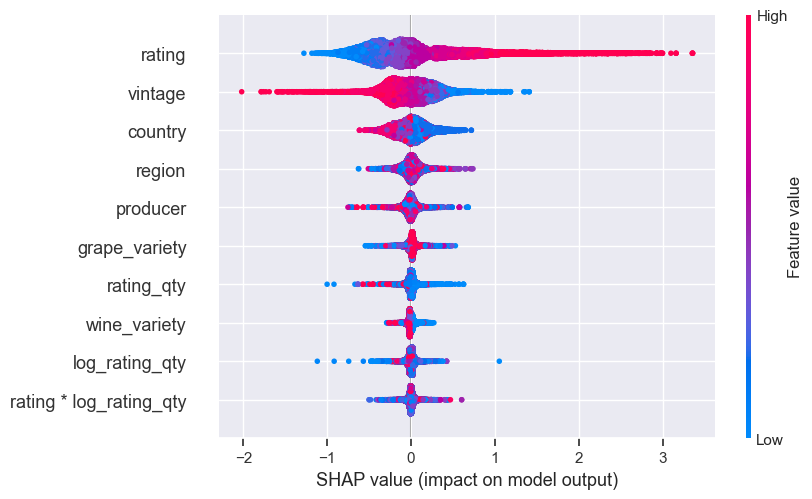

In [40]:
# taking hours to run for some reason 
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train_dt)
shap.plots.beeswarm(shap_values);

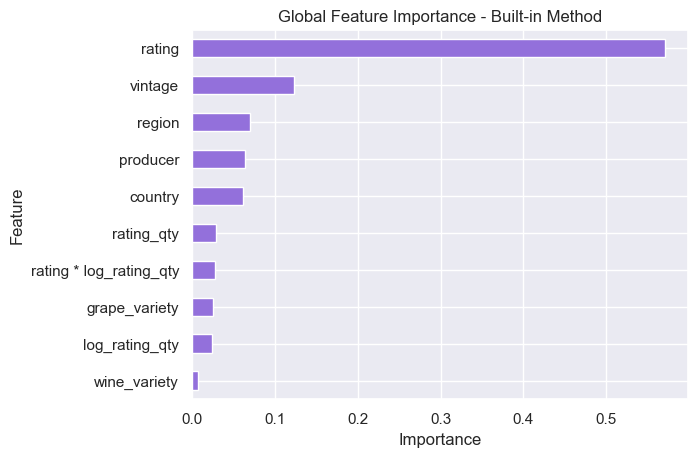

In [41]:
# code from https://forecastegy.com/posts/feature-importance-in-random-forests/
global_importances = pd.Series(best_model.feature_importances_, index=X_train_dt.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='mediumpurple')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance");

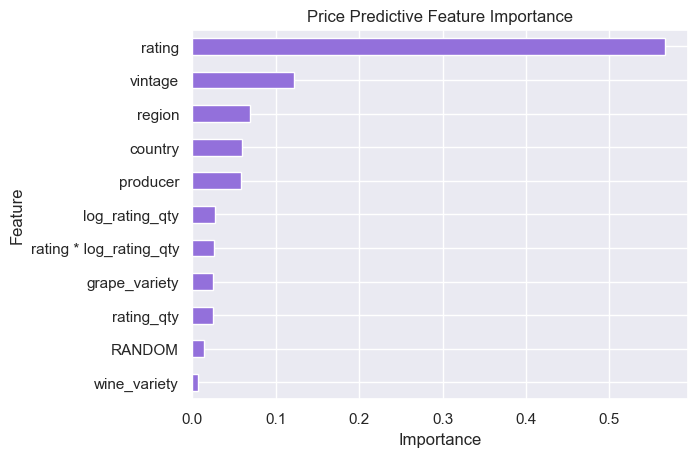

In [57]:
# Verifying feature importance with a comparison to a random variable
# code from https://forecastegy.com/posts/feature-importance-in-random-forests/

X_train_random = X_train_dt.copy()
X_train_random["RANDOM"] = np.random.RandomState(42).randn(X_train_dt.shape[0])

dtree_random_feat_imp = DecisionTreeRegressor(max_depth = None, min_samples_leaf = 1, min_samples_split = 3, random_state=42)
dtree_random_feat_imp.fit(X_train_random, y_train_dt)

global_importances_random = pd.Series(dtree_random_feat_imp.feature_importances_, index=X_train_random.columns)
global_importances_random.sort_values(ascending=True, inplace=True)
global_importances_random.plot.barh(color='mediumpurple')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Price Predictive Feature Importance");

## Recursive Feature Elimination

Recursive Feature Elimination (RFE) - as another method to see most important features in the dataset.

In [58]:
ref_model = RFE(estimator=best_model, n_features_to_select=6, step=1)
ref_model.fit(X_train_dt, y_train_dt)

print("Feature ranking (1 indicates selected):", ref_model.ranking_)
print("Mask of selected features:", ref_model.support_)

selected_features = X_decision_trees.columns[ref_model.support_]
print("Selected features:", selected_features)

Feature ranking (1 indicates selected): [1 1 1 1 5 3 1 4 1 2]
Mask of selected features: [ True  True  True  True False False  True False  True False]
Selected features: Index(['region', 'country', 'vintage', 'producer', 'rating', 'log_rating_qty'], dtype='object')


#

# Exporting files for the App

In [44]:
filepath = '../models/casi_dt_production.pkl'
with gzip.open(filepath, "wb") as f:
    pickled = pickle.dumps(best_model)
    optimized_pickle = pickletools.optimize(pickled)
    f.write(optimized_pickle)

In [45]:
filepath = '../models/casi_rf_production.pkl'
with gzip.open(filepath, "wb") as f:
    pickled = pickle.dumps(rf_best_model)
    optimized_pickle = pickletools.optimize(pickled)
    f.write(optimized_pickle)

In [ ]:
filepath = '../models/casi_rf_production.pkl'
with gzip.open(filepath, "wb") as f:
    pickled = pickle.dumps(rf_best_model)
    optimized_pickle = pickletools.optimize(pickled)
    f.write(optimized_pickle)

## Sandbox

In [62]:
# # SAND BOX RUN FROM HERE 

df_backend = pd.read_csv('../data/app_backend.csv')
df_frontend = pd.read_csv('../data/app_frontend.csv')

# Select a random row
random_index = random.randint(0, len(df_backend) - 1)
random_row_b = df_backend.loc[random_index]
random_row_f = df_frontend.loc[random_index]

In [69]:
random_row_f.index

Index(['name', 'Region', 'Country', 'Vintage', 'Producer', 'Wine Variety',
       'Grape Variety', 'Price ($)', 'Average Rating', 'ABV', 'Log Price',
       'Age'],
      dtype='object')

In [66]:
random_row_b.index

Index(['region', 'country', 'vintage', 'producer', 'wine_variety',
       'grape_variety', 'rating', 'rating_qty', 'log_price', 'log_rating_qty',
       'rating * log_rating_qty'],
      dtype='object')

In [68]:
df['rating_qty'].median()

150.0